In [1]:
import os
import sys

import matplotlib.pyplot as plt

os.chdir('..')

import numpy as np
import torch
import pandas as pd
from models.TrainPlanningOperator2D import PlanningOperator2D, smooth_chi
from models.utilities import LpLoss




Load Test Maps

In [3]:
os.getcwd()

'/home/sharath/Documents/Existensial Robotics Lab/Planning_Operator/2D_Experiments'

In [11]:
lrs = [5e-3]
gammas = [0.5]
wds = [3e-6]
smooth_coefs = [5.]
smooth_coef = smooth_coefs[0]
# experiments to be replicated with different seeds
seeds = [5, 2000, 14000, 16000, 100000]
seeds = [seeds[0]]

modes = 12
width = 32
nlayers = 5

################################################################
#                       configs
################################################################
Ntotal = 550
ntrain = 500
ntest = Ntotal-ntrain

batch_size = 1

epochs = 501
scheduler_step = 100
tol_early_stop = 500


sub = 1
Sx = int(((512 - 1) / sub) + 1)
Sy = Sx

mask = np.load('dataset/street_maps_512x512_dijkstra/mask.npy')
mask = torch.tensor(mask, dtype=torch.float)
dist_in = np.load('dataset/street_maps_512x512_dijkstra/dist_in.npy')
dist_in = torch.tensor(dist_in[:Ntotal, :, :], dtype=torch.float)
input = smooth_chi(mask, dist_in, smooth_coef)
output = np.load('dataset/street_maps_512x512_dijkstra/output.npy')
output = torch.tensor(output, dtype=torch.float)

goals = np.load('dataset/street_maps_512x512_dijkstra/goals.npy')
goals = torch.tensor(goals, dtype=torch.float)



mask_train = mask[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
mask_test = mask[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

mask_train = mask_train.reshape(ntrain, Sx, Sy, 1)
mask_test = mask_test.reshape(ntest, Sx, Sy, 1)

chi_train = input[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
chi_test = input[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

chi_train = chi_train.reshape(ntrain, Sx, Sy, 1)
chi_test = chi_test.reshape(ntest, Sx, Sy, 1)

y_train = output[:Ntotal][:ntrain, ::sub, ::sub][:, :Sx, :Sy]
y_test = output[:Ntotal][-ntest:, ::sub, ::sub][:, :Sx, :Sy]

y_train = y_train.reshape(ntrain, Sx, Sy, 1)
y_test = y_test.reshape(ntest, Sx, Sy, 1)

goals_train = goals[:ntrain]
goals_test = goals[-ntest:]

goals_train = goals_train.reshape(ntrain, 2, 1)
goals_test = goals_test.reshape(ntest, 2, 1)


train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_train, chi_train, y_train, goals_train),
                                            batch_size=batch_size,
                                            shuffle=True)
test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(mask_test, chi_test, y_test, goals_test),
                                            batch_size=batch_size,
                                            shuffle=False)

In [14]:
modes = 13
width = 32
nlayers = 5

model = PlanningOperator2D(modes, modes, width, nlayers)
model.load_state_dict(torch.load("trained_models/modeldijkstra512.ckpt"))
model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


myloss = LpLoss(size_average=False)
rel_error = 0
abs_error = 0
count = 0
with torch.no_grad():
    for batch_id, (mask, chi, ground_truth, gg) in enumerate(test_loader):
        mask, chi, ground_truth, gg = mask.to(device), chi.to(device), ground_truth.to(device), gg.to(device)
        
        out1 = model(chi, gg)
        out1 = out1*mask
        rel_error += myloss(out1, ground_truth).item()
        abs_error += myloss.abs(out1, ground_truth).item()
        count += 1
print("Relative Loss:",rel_error/(count*batch_size))        
print("Abs Loss:",abs_error/(count*batch_size))      

Relative Loss: 0.11054375007748604
Abs Loss: 31.46336051940918


Planning Operator

In [4]:
# Model

erosion_values = []
avgpathcost_values = []
avgplantime_values = []
avginfertime_values = []
avgnodesexp_values = []
avgsuccessrate_values = []

# NO
print("Testing NO")
no_results = testheuristiconmaps(startpositions, goalpositions, maps, planningoperator,  model=model,plotresults=False, printvalues=True, erosion = 12)


Testing NO
Average Path Cost: 323.64248173426455 
Average Planning Time: 0.15565487384796142 
Average Inference Time: 0.15095397472381591 
Average Number of Node Expansions: 2743.5 
Average Success Rate: 1.0


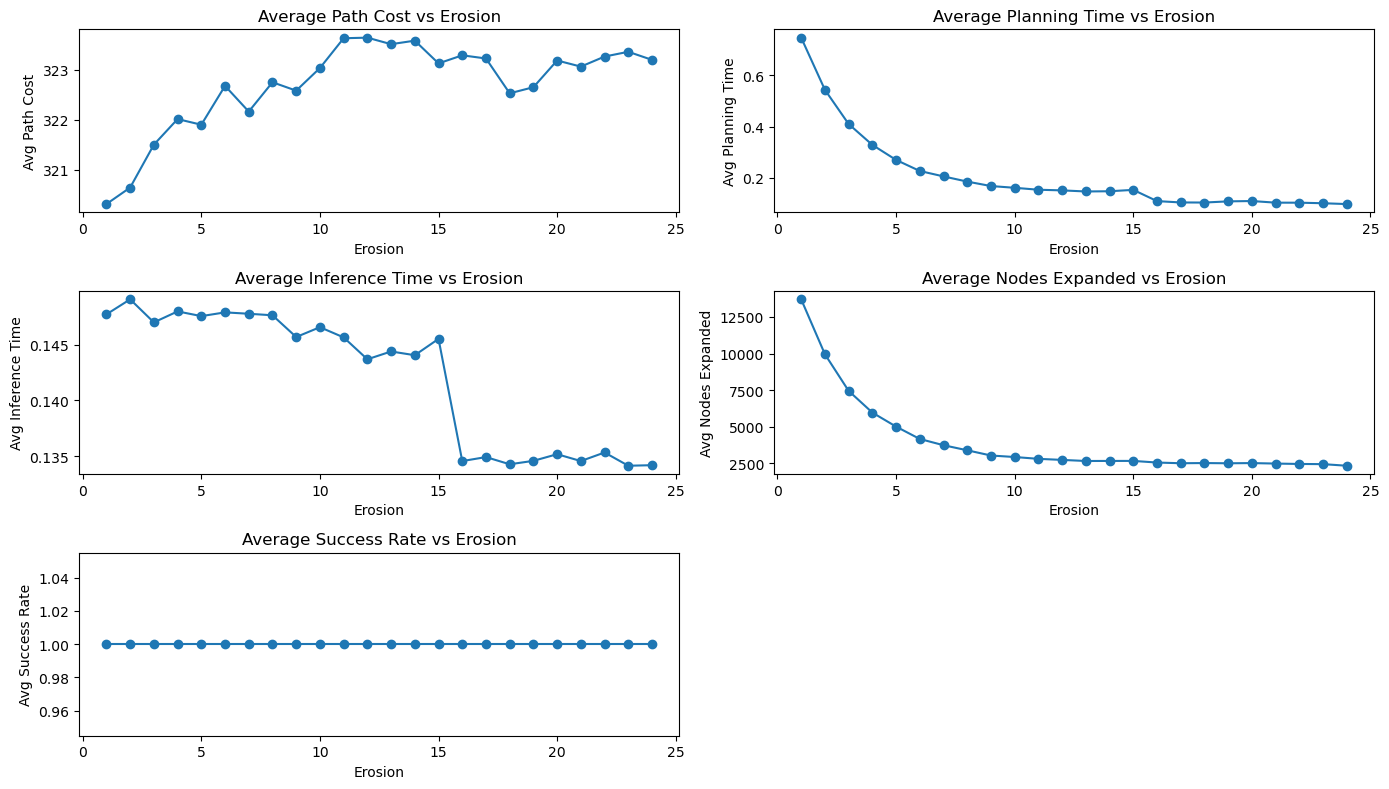

In [5]:

# Run the loop and store results
for erode in range(1, 25):
    
    # Call your function and store the results
    avgpathcost, avgplantime, avginfertime, avgnodesexp, avgsuccessrate = testheuristiconmaps(
        startpositions, goalpositions, maps, planningoperator, model=model, erosion=erode, plotresults=False, printvalues=False
    )
    
    # Append results to lists
    erosion_values.append(erode)
    avgpathcost_values.append(avgpathcost)
    avgplantime_values.append(avgplantime)
    avginfertime_values.append(avginfertime)
    avgnodesexp_values.append(avgnodesexp)
    avgsuccessrate_values.append(avgsuccessrate)

# Plotting the results
plt.figure(figsize=(14, 8))

# Plot for avgpathcost
plt.subplot(3, 2, 1)
plt.plot(erosion_values, avgpathcost_values, marker='o')
plt.title('Average Path Cost vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Path Cost')

# Plot for avgplantime
plt.subplot(3, 2, 2)
plt.plot(erosion_values, avgplantime_values, marker='o')
plt.title('Average Planning Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Planning Time')

# Plot for avginfertime
plt.subplot(3, 2, 3)
plt.plot(erosion_values, avginfertime_values, marker='o')
plt.title('Average Inference Time vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Inference Time')

# Plot for avgnodesexp
plt.subplot(3, 2, 4)
plt.plot(erosion_values, avgnodesexp_values, marker='o')
plt.title('Average Nodes Expanded vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Nodes Expanded')

# Plot for avgsuccessrate
plt.subplot(3, 2, 5)
plt.plot(erosion_values, avgsuccessrate_values, marker='o')
plt.title('Average Success Rate vs Erosion')
plt.xlabel('Erosion')
plt.ylabel('Avg Success Rate')

# Adjust layout and show the plot
plt.tight_layout()
plt.show()

In [1]:
map 

map